## Importing the necessary modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import cross_validation
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.grid_search import GridSearchCV
%matplotlib inline

/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
df = pd.read_csv("../input/Loan payments data.csv")

In [3]:
df.head(5)

,Loan_ID,loan_status,Principal,terms,effective_date,due_date,paid_off_time,past_due_days,age,education,Gender
0,xqd20166231,PAIDOFF,1000,30,09/08/16,10/07/16,9/14/2016 19:31,NaN,45,High School or Below,male
1,xqd20168902,PAIDOFF,1000,30,09/08/16,10/07/16,10/07/16 9:00,NaN,50,Bechalor,female
2,xqd20160003,PAIDOFF,1000,30,09/08/16,10/07/16,9/25/2016 16:58,NaN,33,Bechalor,female
3,xqd20160004,PAIDOFF,1000,15,09/08/16,9/22/2016,9/22/2016 20:00,NaN,27,college,male
4,xqd20160005,PAIDOFF,1000,30,09/09/16,10/08/16,9/23/2016 21:36,NaN,28,college,female


In [4]:
df.shape

(454, 11)

In [5]:
df.describe()  #missing values in past_due_days

,Principal,terms,past_due_days,age
count,454.000000,454.000000,170.000000,454.000000
mean,940.969163,22.625551,36.341176,30.973568
std,118.284029,8.055320,29.557507,6.103537
min,300.000000,7.000000,1.000000,18.000000
25%,900.000000,15.000000,3.000000,26.000000
50%,1000.000000,30.000000,44.000000,30.000000
75%,1000.000000,30.000000,60.000000,35.000000
max,1000.000000,30.000000,76.000000,51.000000


## Analysing the attributes

In [6]:
len(df.Loan_ID.unique()) # verifying uniqueness of ids since they are unique they are not required

454

In [7]:
del df['Loan_ID']

In [8]:
loan_status = df['loan_status'].unique()
loan_status

array(['PAIDOFF', 'COLLECTION', 'COLLECTION_PAIDOFF'], dtype=object)

In [9]:
def change_loan_status(str):  #there might be 4 classes as suggested by metadata available(but only 3 inthe given dataset)
    if str == loan_status[0]:
        return 1
    elif str == loan_status[1]:
        return 2
    elif str == loan_status[2]:
        return 3  
    else:
        return 4
df['loan_status'] = df['loan_status'].apply(change_loan_status)    

In [10]:
df.groupby('loan_status').agg(['count'])   #Many people have paid their loans on time

,Principal,terms,effective_date,due_date,paid_off_time,past_due_days,age,education,Gender
,count,count,count,count,count,count,count,count,count
loan_status,,,,,,,,,
1,284,284,284,284,284,0,284,284,284
2,85,85,85,85,0,85,85,85,85
3,85,85,85,85,85,85,85,85,85


In [11]:
df['Principal'].unique()

array([1000,  300,  800,  900,  700,  500])

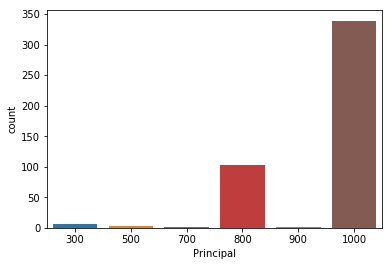

In [12]:
sns.countplot(x = 'Principal', data = df) #principal amount in range[800 - 1000] preferred

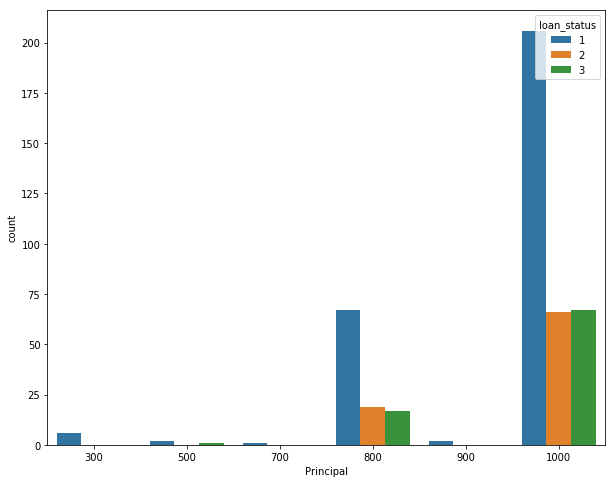

In [13]:
plt.figure(figsize = (10, 8))   #demonstrates principal taken loan_status-wise
sns.countplot(x='Principal', hue = "loan_status", data = df)

In [14]:
df['terms'].unique()

array([30, 15,  7])

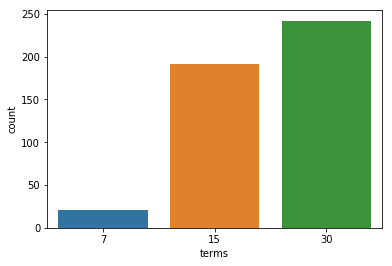

In [15]:
sns.countplot(x = 'terms', data = df) #bi-weekly and monthly loans are preferred(was predictable)

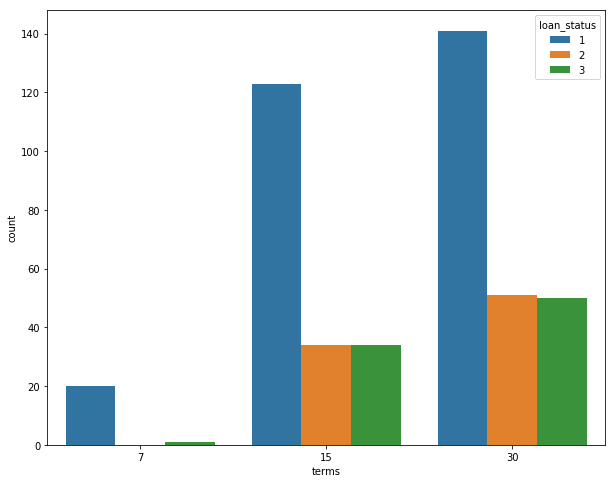

In [16]:
plt.figure(figsize = (10, 8))   #demonstrates principal taken loan_status-wise
sns.countplot(x='terms', hue = "loan_status", data = df) #surprising fact that weekly loans are mostly paid at time

In [17]:
df['effective_date'].unique()

array(['09/08/16', '09/09/16', '09/10/16', '09/11/16', '09/12/16',
       '9/13/2016', '9/14/2016'], dtype=object)

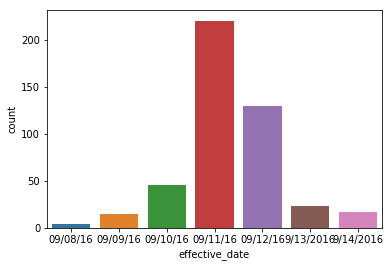

In [18]:
sns.countplot(x = 'effective_date', data = df) #most loans taken at 9/11/16

In [19]:
del df['effective_date'] #but since past_due_days data is available, these attributes are of no use
del df['due_date']
del df['paid_off_time']

In [20]:
df1 = df.copy()

In [21]:
df1.past_due_days.fillna(0, inplace = True)

In [22]:
df1[df1.past_due_days == 0].shape #All the paidoff loans have no past_due_days(obvious)

(284, 7)

In [23]:
del df['past_due_days'] #retaining this feature in 1 copy and not in the other

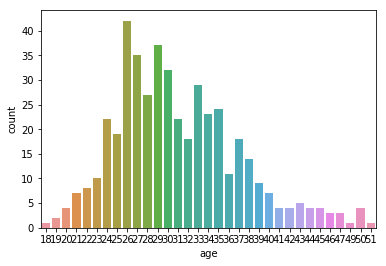

In [24]:
sns.countplot(x = 'age', data = df) #most of the loans are taken up by the age bracket [20-40] older and younger people dont take much loans acc. to data

In [25]:
mean_age_paidoff = df['age'][df.loan_status == 1].mean()      #not much difference in the average ages
mean_age_collection = df['age'][df.loan_status == 2].mean()
mean_age_collpaidoff = df['age'][df.loan_status == 3].mean()
[mean_age_paidoff, mean_age_collection, mean_age_collpaidoff]

[31.158450704225352, 30.352941176470587, 30.976470588235294]

In [26]:
loan_educ = df['education'].unique()
loan_educ

array(['High School or Below', 'Bechalor', 'college', 'Master or Above'], dtype=object)

In [27]:
def change_loan_educ(str):
    if str == loan_educ[0]:
        return 1
    elif str == loan_educ[1]:
        return 2
    elif str == loan_educ[2]:
        return 3  
    else:
        return 4
df['education'] = df['education'].apply(change_loan_educ)
df1['education'] = df1['education'].apply(change_loan_educ)

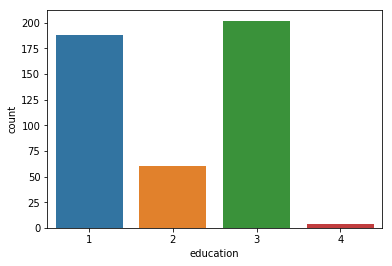

In [28]:
sns.countplot(x = 'education', data = df) #very few have done masters(many are not enough educated)

In [29]:
df['age'][df.education == 1].mean()  #this infers most of people(middle-aged) have not even graduated(this is also close to the mean age of the paidoff loans)

31.095744680851062

In [30]:
lb = LabelEncoder()
df['Gender'] = lb.fit_transform(df['Gender'])# 0-female, 1- male
df1['Gender'] = lb.fit_transform(df1['Gender'])# 0-female, 1- male

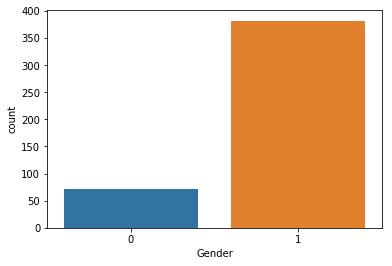

In [31]:
sns.countplot(x = 'Gender', data = df) #mostly males have taken up loans

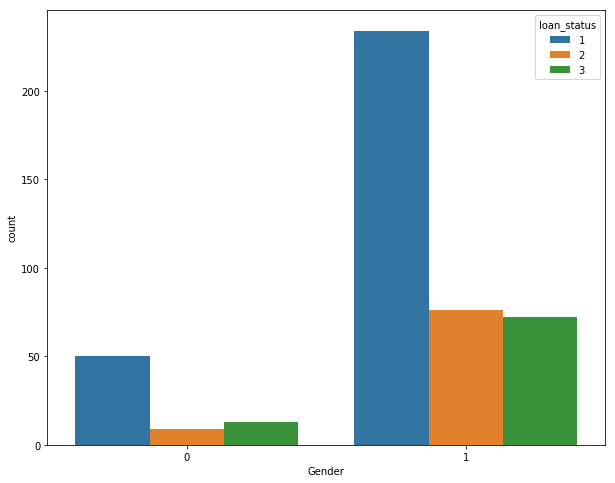

In [32]:
plt.figure(figsize = (10, 8))   
sns.countplot(x='Gender', hue = "loan_status", data = df) 

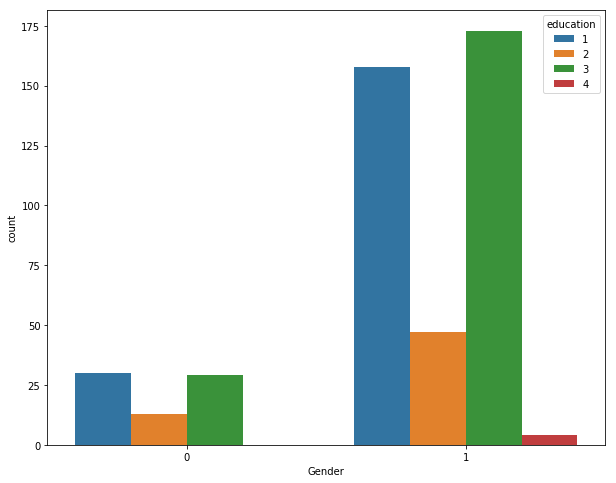

In [33]:
plt.figure(figsize = (10, 8))   
sns.countplot(x='Gender', hue = "education", data = df) #most females have completed higher-education(many ungraduated males)

In [34]:
def plot_correlation_map( df ):
    corr = df.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )

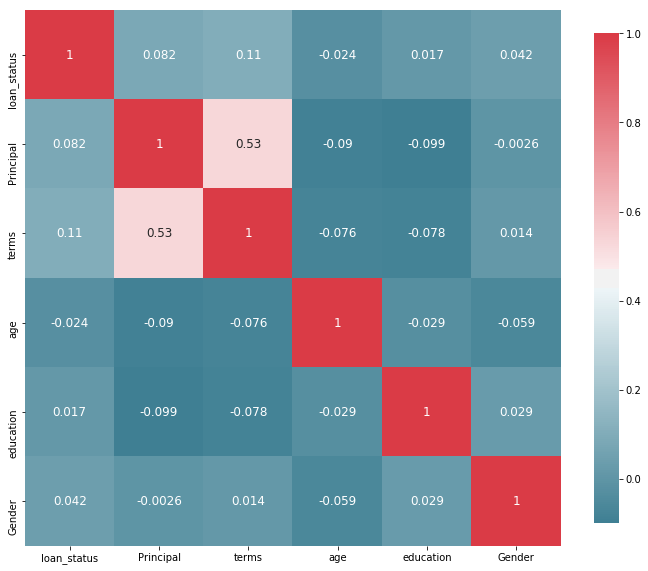

In [35]:
plot_correlation_map(df)

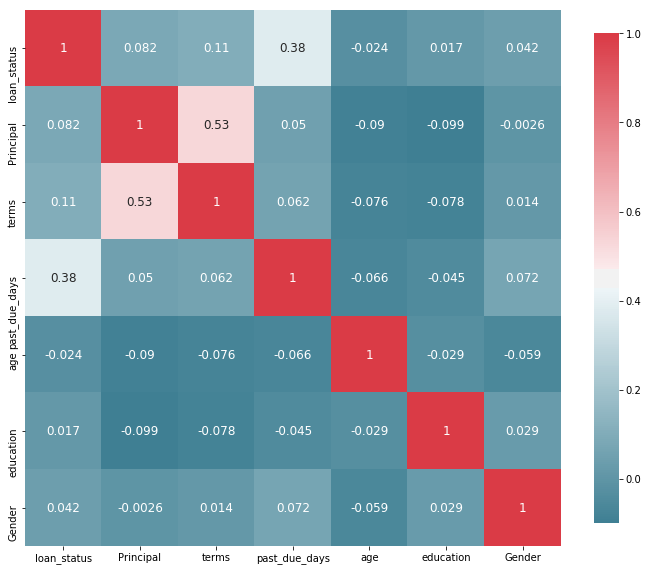

In [36]:
plot_correlation_map(df1)

## Applying models without dummy encoding applied

In [37]:
x_train, x_test, y_train, y_test = cross_validation.train_test_split(df.iloc[:, 1:], df['loan_status'], test_size = 0.25)

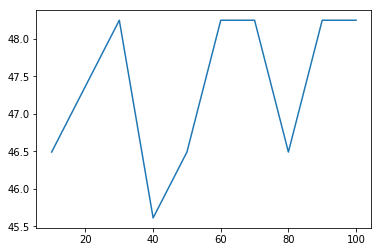

In [38]:
input_params = np.arange(10, 101, 10)  #optimal n_estimators is for 50
l = []
for i in input_params:
    rfc = RandomForestClassifier(n_estimators = i) 
    rfc.fit(x_train, y_train)
    l.append(rfc.score(x_test, y_test)*100)
#print(l)    
plt.plot(input_params, l)

In [39]:
rfc.feature_importances_

array([ 0.06523587,  0.0808465 ,  0.71215786,  0.09575889,  0.04600088])

In [40]:
x_train1, x_test1, y_train1, y_test1 = cross_validation.train_test_split(df1.iloc[:, 1:], df1['loan_status'], test_size = 0.25)

## Random Forest

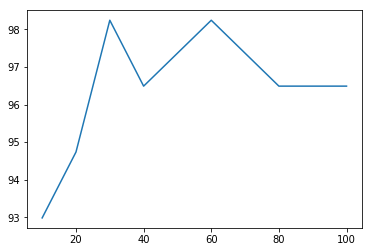

In [41]:
input_params = np.arange(10, 101, 10)  #optimal n_estimators is for 50
l = []
for i in input_params:
    rfc1 = RandomForestClassifier(n_estimators = i)  #huge change in accuracy with retaining past_due_days feature
    rfc1.fit(x_train1, y_train1)
    l.append((cross_val_score(rfc1, x_test1, y_test1).mean())*100)
    #Handles sparse attributes better but fails on some outliers
#print(l)
plt.plot(input_params, l)

In [43]:
optimal_pt = l[1]   #optimal point(after this,most possibly, overfitting takes place)

In [44]:
rfc1.feature_importances_ #giving past_due_days very high importance(almost classifying only on the basis of it)

array([ 0.00902018,  0.016469  ,  0.88656016,  0.05854231,  0.02140857,
        0.00799978])

## Support Vector Machine(SVM)

In [45]:
params = [{'kernel' : ['rbf', 'linear'], 'C' : [1, 5, 10, 100], 'gamma' : [0.00005, 0.0005, 0.005]}]
clf = GridSearchCV(svm.SVC(), params)#parameter tuning done
clf.fit(x_train, y_train)
print(cross_val_score(clf, x_test, y_test).mean()*100)

64.0417745681


In [46]:
clf1 = GridSearchCV(svm.SVC(), params)
clf1.fit(x_train1, y_train1)
print(cross_val_score(clf1, x_test1, y_test1).mean()*100)

97.3684210526


## XGBoost Classifier

In [47]:
xb = XGBClassifier()
xb.fit(x_train, y_train)
print(cross_val_score(xb, x_test, y_test).mean()*100)

46.5593123488


In [48]:
xb1 = XGBClassifier()
xb1.fit(x_train, y_train)
print(cross_val_score(xb1, x_test1, y_test1).mean()*100)

97.3684210526


In [49]:
y_pred = clf1.predict(x_test1) #therefore, paramaters others than accuracy are really good via parameter-tuned svm
print(classification_report(y_test1, y_pred))

             precision    recall  f1-score   support

          1       1.00      1.00      1.00        63
          2       1.00      0.87      0.93        30
          3       0.84      1.00      0.91        21

avg / total       0.97      0.96      0.97       114



## Applying dummy encoding

In [55]:
ohe = OneHotEncoder(categorical_features = [5])   #done in df
#applied on gender not on education(because we can assign some weightage acc. to education but not acc. to gender)
df = pd.DataFrame(ohe.fit_transform(df).toarray()) #first column - female presence second - male presence

In [58]:
ohe = OneHotEncoder(categorical_features = [6])  #done in df1
df1 = pd.DataFrame(ohe.fit_transform(df1).toarray()) #first column - female presence second - male presence

## Avoiding Dummy Trap

In [61]:
del df[0]
del df1[0]

In [65]:
y = df[2]
del df[2]
del df1[2]

In [68]:
x_train, x_test, y_train, y_test = cross_validation.train_test_split(df, y, test_size = 0.25)

In [69]:
x_train1, x_test1, y_train1, y_test1 = cross_validation.train_test_split(df1, y, test_size = 0.25)

## Random forest

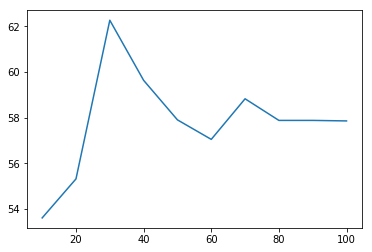

In [70]:
input_params = np.arange(10, 101, 10)  #optimal n_estimators is for 50
l = []
for i in input_params:
    rfc = RandomForestClassifier(n_estimators = i)  #huge change in accuracy with retaining past_due_days feature
    rfc.fit(x_train, y_train)
    l.append((cross_val_score(rfc, x_test, y_test).mean())*100)
    #Handles sparse attributes better but fails on some outliers
#print(l)
plt.plot(input_params, l)

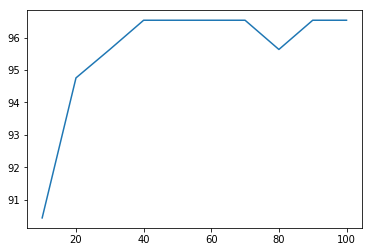

In [71]:
input_params = np.arange(10, 101, 10)  #optimal n_estimators is for 50
l = []
for i in input_params:
    rfc1 = RandomForestClassifier(n_estimators = i)  #huge change in accuracy with retaining past_due_days feature
    rfc1.fit(x_train1, y_train1)
    l.append((cross_val_score(rfc1, x_test1, y_test1).mean())*100)
    #Handles sparse attributes better but fails on some outliers
#print(l)
plt.plot(input_params, l)

In [72]:
l  #the flattening plateau indicates that this is the optimal point

[90.43841412262465,
 94.756902651639493,
 95.63409563409563,
 96.534996534996537,
 96.534996534996537,
 96.534996534996537,
 96.534996534996537,
 95.63409563409563,
 96.534996534996537,
 96.534996534996537]

## Support Vector Machine(SVM)

In [74]:
params = [{'kernel' : ['rbf', 'linear'], 'C' : [1, 5, 10, 100], 'gamma' : [0.00005, 0.0005, 0.005]}]
clf = GridSearchCV(svm.SVC(), params)#parameter tuning done
clf.fit(x_train, y_train)
print(cross_val_score(clf, x_test, y_test).mean()*100)

60.5542789753


In [75]:
clf1 = GridSearchCV(svm.SVC(), params) #Think that svm is overfitting in both this case and the above one without dummy encoding
clf1.fit(x_train1, y_train1)
print(cross_val_score(clf1, x_test1, y_test1).mean()*100)

99.1452991453


## XGBoost Classifier

In [76]:
xb = XGBClassifier()
xb.fit(x_train, y_train)
print(cross_val_score(xb, x_test, y_test).mean()*100)

56.1409587725


In [77]:
xb1 = XGBClassifier()   #in this case as well as in svm we are getting same accuracy this also happend in the case without one hot encoding
xb1.fit(x_train, y_train)
print(cross_val_score(xb1, x_test1, y_test1).mean()*100)

99.1452991453


## Final Accuracy And Results

In [79]:
l[4]   #This is the final accuracy(because in my view SVM and XGBoost are overfitting and are behaving similarly)

96.534996534996537